In [151]:
from datasets import load_dataset, Dataset
from IPython.display import display
from PIL import Image
import numpy as np
import pandas as pd
import pycountry
from pprint import pprint
from typing import Callable, Tuple
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
from matplotlib.lines import Line2D


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from mpl_toolkits.mplot3d import Axes3D  # This import registers the 3D projection

# Model imports
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [4]:
def alpha2_to_name(code):
    try:
        return pycountry.countries.get(alpha_2=code).name
    except:
        return None

## Part 1 - Loading Data and exploring it

#### We will apply to only 5 countries in the reserach for easier analysis, faster training times and specified answers
Israel, USA, Japan, Nigeria, Denmark 


In [103]:
# Exploration and pre-processing functions and parameters

SELECTED_COUNTRIES = ['IL','US','JP','NG','DE']


def count_labels(label_list: list | np.ndarray) -> dict:
    """
    Counts the labels of the datasets in order to check if there is class instability.
    """
    list_as_array = np.array(label_list)
    labels, label_counts = np.unique(list_as_array, return_counts=True)

    final_counts = dict(zip(labels.astype(int), label_counts.astype(int)))
    pprint(final_counts)


def keep_samples_by_label(sample):
    return sample["label"] in SELECTED_COUNTRIES


def build_array_df_from_dataset(dataset, to_grey_scale: bool = False) -> pd.DataFrame:
    def process_sample(sample):
        return {
            "image_array": np.array(sample["image"].resize((128, 128)) if not to_grey_scale else sample["image"].convert("L").resize((128,128))),
            "label": sample["label"]
        }    

    processed_filtered_ds = dataset.map(process_sample)
    df = pd.DataFrame({
    "image_array": processed_filtered_ds["image_array"],
    "label": processed_filtered_ds["label"]
    })

    return df




In [58]:
# Load the datasets
dataset = load_dataset("nateraw/country211")
dataset_train, dataset_validation, dataset_test = dataset["train"], dataset["validation"], dataset["test"]
datasets = (dataset_train, dataset_validation, dataset_test)

In [123]:
# This is a callable that saves the mapping of labels to their string representation
label2country = dataset_train.features["label"].int2str

# This is the inverse of the above
country2label = dataset_train.features["label"].str2int

def count_labels(label_column: np.ndarray) -> dict:
    labels_as_strings = list(label2country(label_column))

    counts = Counter(labels_as_strings)
    return dict(counts)

In [62]:
datasets_filtered = tuple(dataset.filter(lambda sample: label2country(sample["label"]) in SELECTED_COUNTRIES) for dataset in datasets)
dataset_train_filtered, dataset_validation_filtered, dataset_test_filtered = datasets_filtered

In [74]:
print("Dataset Shapes Before   ->  After")
print(f"Train:       {dataset_train.shape} -> {dataset_train_filtered.shape}")
print(f"Validation:  {dataset_validation.shape} -> {dataset_validation_filtered.shape}")
print(f"Test:        {dataset_test.shape} -> {dataset_test_filtered.shape}")

Dataset Shapes Before   ->  After
Train:       (31650, 2) -> (750, 2)
Validation:  (10550, 2) -> (250, 2)
Test:        (21100, 2) -> (500, 2)


### With the new datasets of filtered countries, we can begin working on the questions

However, in order to work with traditional ML, which in our case will be SVM and RF, we need an array of features. For that the data will be transformed to arrays, and in the case of colored images, 3d arrays. 

3D arrays while representative, pose an issue with training for traditional ML. It is usually recommended to use 1d arrays that represent features. In the case of images, each pixel can be seen as a feature but it has the trade-off of losing relational information of neighboring pixels. Therefore, flattering will be required, but at a cost of model accuracy which we will later see.

In the following section, we will create 2 types of dataframes: One of RGB images as array, and one as greyscale images as array. Those will also be flattened in order to support training them with ML tasks and with exploring by PCA 

In [13]:
def build_df_from_dataset(dataset) -> pd.DataFrame:
    def process_sample(sample):
        return {
            "image_array": np.array(sample["image"].convert("L").resize((128,128))).flatten(), # Converts image to Grayscale
            "label": sample["label"]
        }    

    processed_filtered_ds = dataset.map(process_sample)
    df = pd.DataFrame({
    "image": processed_filtered_ds["image_array"],
    "label": processed_filtered_ds["label"]
    })

    return df

In [104]:
# Build the relevant dataframes for future data exploration and analysis 

print("Building RGB dataframes")
data_frames_rgb = tuple(build_array_df_from_dataset(filtered_ds, to_grey_scale=False) for filtered_ds in datasets_filtered)

print("Building greyscale dataframes")
data_frames_greyscale = tuple(build_array_df_from_dataset(filtered_ds, to_grey_scale=True) for filtered_ds in datasets_filtered)

Map: 100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 105.60 examples/s]


In [105]:
df_train_rgb, df_validation_rgb, df_test_rgb = data_frames_rgb
df_train_grey, df_validation_grey, df_test_grey = data_frames_greyscale

In [108]:
np.array(df_train_grey["image_array"][0]).shape

(128, 128)

In [133]:
# Checking data instability

print(f"Images train data label counts:      {count_labels(dataset_train_filtered["label"])}")
print(f"Images validation data label counts: {count_labels(dataset_validation_filtered["label"])}")
print(f"Images test data label counts:       {count_labels(dataset_test_filtered["label"])}")

print()

print(f"DF-RGB train data label counts:      {count_labels(df_train_rgb["label"])}")
print(f"DF-RGB validation data label counts: {count_labels(df_validation_rgb["label"])}")
print(f"DF-RGB test data label counts:       {count_labels(df_test_rgb["label"])}")

print()

print(f"DF-grey train data label counts:      {count_labels(df_train_grey["label"])}")
print(f"DF-grey validation data label counts: {count_labels(df_validation_grey["label"])}")
print(f"DF-grey test data label counts:       {count_labels(df_test_grey["label"])}")


Images train data label counts:      {'DE': 150, 'IL': 150, 'JP': 150, 'NG': 150, 'US': 150}
Images validation data label counts: {'DE': 50, 'IL': 50, 'JP': 50, 'NG': 50, 'US': 50}
Images test data label counts:       {'DE': 100, 'IL': 100, 'JP': 100, 'NG': 100, 'US': 100}

DF-RGB train data label counts:      {'DE': 150, 'IL': 150, 'JP': 150, 'NG': 150, 'US': 150}
DF-RGB validation data label counts: {'DE': 50, 'IL': 50, 'JP': 50, 'NG': 50, 'US': 50}
DF-RGB test data label counts:       {'DE': 100, 'IL': 100, 'JP': 100, 'NG': 100, 'US': 100}

DF-grey train data label counts:      {'DE': 150, 'IL': 150, 'JP': 150, 'NG': 150, 'US': 150}
DF-grey validation data label counts: {'DE': 50, 'IL': 50, 'JP': 50, 'NG': 50, 'US': 50}
DF-grey test data label counts:       {'DE': 100, 'IL': 100, 'JP': 100, 'NG': 100, 'US': 100}


# Q1

This leads to exploring one of the questions: Can we present if the countries are similar and which are different based on the features alone? In order to visualize it we need to use PCA, which is a dimentionality reduction technique that preserves the variance with a fixed number of dimentions. We can reduce to 3 or 2 dimentions but retain the information.

In [165]:
def plot_pca(X, labels, n_components=2, title="PCA Projection", normalize=True):
    # Standardize
    if normalize:
        X = StandardScaler().fit_transform(X)

    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)

    unique_labels, labels_numeric = np.unique(labels, return_inverse=True)

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(1, 1, 1) if n_components == 2 else fig.add_subplot(1, 1, 1, projection='3d')

    if n_components == 2:
        scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_numeric, alpha=0.7)
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
    else:
        scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=labels_numeric, alpha=0.7)
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        ax.set_zlabel("PC3")

    ax.set_title(title)

    # Automatic legend with default colors from scatter
    handles, _ = scatter.legend_elements()
    ax.legend(handles, unique_labels, title="Labels", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

In [140]:
# Start with flattening the data from the datasets

# RGB flatten
X_rgb = np.stack([np.array(img).reshape(-1) for img in df_train_rgb["image_array"]])

# RGB flatten
X_gray = np.stack([np.array(img).reshape(-1) for img in df_train_grey["image_array"]])

In [142]:
print(f"RGB flattened data shape:  {X_rgb.shape}")
print(f"grey flattened data shape: {X_gray.shape}")

RGB flattened data shape:  (750, 49152)
grey flattened data shape: (750, 16384)


In [158]:
labels_rgb, labels_grey = label2country(df_train_rgb['label']), label2country(df_train_grey['label'])

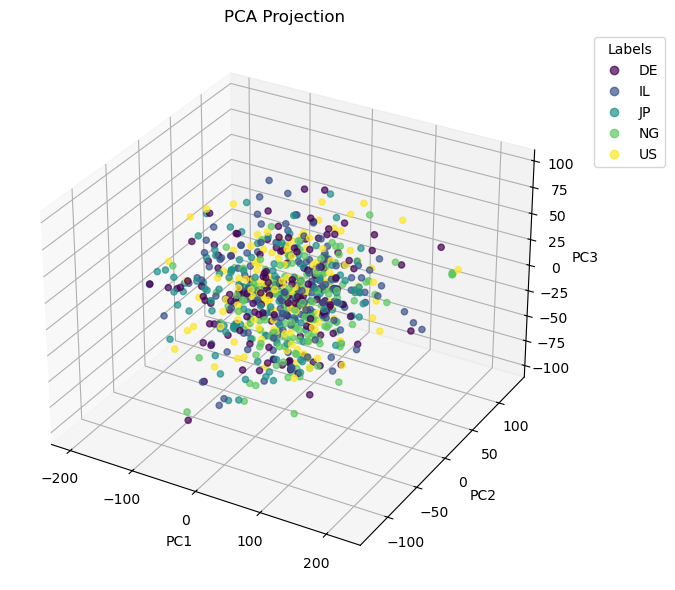

In [167]:
plot_pca(X_gray, labels_grey, n_components=3)

## Training and evaluating models

In [49]:
X_train, X_validation, X_test = tuple(np.stack(data_frame["image"].values) for data_frame in data_frames)
y_train, y_validation, y_test = tuple(np.stack(data_frame["label"].values) for data_frame in data_frames)


# PCA for dimentionality reduction
X_train_pca, X_validation_pca, X_test_pca = apply_PCA(X_train, y_train), apply_PCA(X_validation, y_validation), apply_PCA(X_test, y_test)

#### SVM

In [50]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_pca)
X_test_scaled = scaler.transform(X_test_pca)

# Step 4: Train SVM
clf = SVC(kernel='linear', C=1.0, gamma='scale')  # you can also try 'linear' kernel
clf.fit(X_train_scaled, y_train)

# Step 5: Evaluate
y_pred = clf.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.06947368421052631
Classification Report:
               precision    recall  f1-score   support

          14       0.06      0.07      0.06       100
          20       0.07      0.06      0.06       100
          71       0.01      0.01      0.01       100
          74       0.14      0.03      0.05       100
          87       0.08      0.02      0.03       100
          92       0.09      0.32      0.14       100
          99       0.00      0.00      0.00       100
         102       0.00      0.00      0.00       100
         103       0.00      0.00      0.00       100
         106       0.05      0.03      0.04       100
         116       0.10      0.08      0.09       100
         121       0.06      0.21      0.09       100
         130       0.50      0.01      0.02       100
         149       0.07      0.26      0.11       100
         151       0.00      0.00      0.00       100
         179       0.06      0.17      0.09       100
         188       0.09    

/home/ely/miniconda3/envs/jupyter_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ely/miniconda3/envs/jupyter_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ely/miniconda3/envs/jupyter_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

#### Random Forest

In [54]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.08894736842105264
Classification Report:
               precision    recall  f1-score   support

          14       0.04      0.04      0.04       100
          20       0.05      0.06      0.05       100
          71       0.08      0.07      0.07       100
          74       0.11      0.15      0.13       100
          87       0.08      0.06      0.07       100
          92       0.08      0.13      0.10       100
          99       0.08      0.05      0.06       100
         102       0.18      0.17      0.18       100
         103       0.09      0.07      0.08       100
         106       0.08      0.08      0.08       100
         116       0.12      0.15      0.13       100
         121       0.06      0.07      0.06       100
         130       0.05      0.04      0.05       100
         149       0.10      0.17      0.13       100
         151       0.14      0.08      0.10       100
         179       0.08      0.07      0.07       100
         188       0.10    

#### Resnet - Deep CNN Model

As a general rule, all the pre-processing of above models wont apply. This section will handle pre-processing and fine-tuning for Resnet specifically

In [11]:
import torch.nn as nn
import torch.optim as optim

import torch
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import functional as TF
from PIL import Image

In [12]:
resnet50 = models.resnet50(pretrained=True)

/home/ely/miniconda3/envs/jupyter_env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ely/miniconda3/envs/jupyter_env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
datasets_for_resnet = datasets_filtered

In [14]:
num_classes = 20
resnet50.fc = nn.Linear(resnet50.fc.in_features, num_classes)

In [15]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [16]:
label_white_list

array([ 30, 173, 140,  75,  60, 208,  45, 183,   9, 100, 137, 204, 156,
        82,  15, 200, 167,  18, 209,  86])

In [17]:
len(label_white_list)

20

In [18]:
label_map = {old: new for new, old in enumerate(label_white_list)}

In [19]:
label_map

{np.int64(30): 0,
 np.int64(173): 1,
 np.int64(140): 2,
 np.int64(75): 3,
 np.int64(60): 4,
 np.int64(208): 5,
 np.int64(45): 6,
 np.int64(183): 7,
 np.int64(9): 8,
 np.int64(100): 9,
 np.int64(137): 10,
 np.int64(204): 11,
 np.int64(156): 12,
 np.int64(82): 13,
 np.int64(15): 14,
 np.int64(200): 15,
 np.int64(167): 16,
 np.int64(18): 17,
 np.int64(209): 18,
 np.int64(86): 19}

In [20]:
len(label_map)

20

In [21]:
class HFImageDataset(Dataset):
    def __init__(self, hf_dataset, transform=None, label_map = label_map):
        self.dataset = hf_dataset
        self.transform = transform
        self.label_map = label_map
        

    def __getitem__(self, idx):
        sample = self.dataset[idx]
        image = sample["image"]
        if isinstance(image, torch.Tensor):
            image = TF.to_pil_image(image)
        if image.mode != "RGB":
            image = image.convert("RGB")
        label = int(sample["label"]) # Remap to 0–19
        label = self.label_map[label]

        if self.transform:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.dataset)

In [22]:
train_ds = HFImageDataset(datasets_for_resnet[0].with_format("torch"), transform=transform)
val_ds = HFImageDataset(datasets_for_resnet[1].with_format("torch"), transform=transform)

In [23]:
img, label = train_ds[3]
label

8

In [24]:
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)

In [25]:
print("train_ds type:", type(train_ds))  # should be HFImageDataset
print("Sample:", train_ds[0][0].shape) 

train_ds type: <class '__main__.HFImageDataset'>
Sample: torch.Size([3, 224, 224])


In [26]:


# Training loop
for epoch in range(5):  # Choose your number of epochs
    resnet50.train()
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        outputs = resnet50(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1} completed.")

cuda


100%|███████████████████████████████████████████| 94/94 [00:21<00:00,  4.44it/s]


Epoch 1 completed.


100%|███████████████████████████████████████████| 94/94 [00:20<00:00,  4.60it/s]


Epoch 2 completed.


100%|███████████████████████████████████████████| 94/94 [00:20<00:00,  4.57it/s]


Epoch 3 completed.


100%|███████████████████████████████████████████| 94/94 [00:20<00:00,  4.54it/s]


Epoch 4 completed.


100%|███████████████████████████████████████████| 94/94 [00:27<00:00,  3.41it/s]

Epoch 5 completed.


In [27]:
train_losses = []
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
resnet50 = resnet50.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.parameters(), lr=1e-4)

for epoch in range(5):
    resnet50.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        outputs = resnet50(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1} completed. Avg Loss: {avg_loss:.4f}")

cuda


100%|███████████████████████████████████████████| 94/94 [00:37<00:00,  2.49it/s]


Epoch 1 completed. Avg Loss: 0.0875


100%|███████████████████████████████████████████| 94/94 [00:37<00:00,  2.48it/s]


Epoch 2 completed. Avg Loss: 0.1623


100%|███████████████████████████████████████████| 94/94 [00:39<00:00,  2.41it/s]


Epoch 3 completed. Avg Loss: 0.1038


100%|███████████████████████████████████████████| 94/94 [00:38<00:00,  2.44it/s]


Epoch 4 completed. Avg Loss: 0.0551


100%|███████████████████████████████████████████| 94/94 [00:38<00:00,  2.44it/s]

Epoch 5 completed. Avg Loss: 0.0462


In [31]:
def get_image_data(dataset_split, index: int, as_array = True) -> (np.ndarray | Image, int):
    image_sample = dataset_split[index]
    image, label = np.array(image_sample["image"]) if as_array else image_sample["image"], image_sample["label"]

    return image, label
    

TypeError: unsupported operand type(s) for |: 'type' and 'module'

In [16]:
# Convert to numpy arrays for convenience

label_array = np.array(ds['label'])

In [73]:
example = ds[1]
img = example["image"].convert("L")   # a PIL Image object
label = example["label"] # integer 0–210 representing country


In [74]:
img.show()
